numpy image arrays:

- test_images

- aug_train_images
- synthetic_images
- combined_images

other:

- trained model (needed to do model.predict to create confusion matrices)
- model history (needed to plot metrics, acc, loss)

In [2]:
from __future__ import absolute_import, division, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import stats
from skimage.transform import resize
from scipy.ndimage import rotate # could use skimage rotate
import sys
import time
#import os
#from astropy.io import fits

# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
## Define functions

def load_and_prep_data(filepath, crop_size=None, downsample_size=None):
    '''
    Load and prepare data from a .npy file
    Returns 3D array of images
    '''
    # Load data
    images = np.load(filepath, allow_pickle=True)
    num_images, image_size, _ = images.shape

    # Sigma clip data
    sigma = 3
    for i in range(num_images):
        _, median, std = stats.sigma_clipped_stats(images[i], sigma=sigma)
        images[i][images[i] < median+sigma*std] = median+sigma*std

    # Crop data
    if crop_size != None:
        low_idx, upper_idx = image_size//2-crop_size//2, image_size//2+crop_size//2
        images = images[:, low_idx:upper_idx, low_idx:upper_idx]

    # Resize data (downsampling)
    if downsample_size != None:
        images = resize(images, (num_images, downsample_size, downsample_size))

    # Normalise data [-1,1]
    for i in range(num_images):
        images[i] = 2*(images[i]-np.min(images[i]))/np.ptp(images[i])-1

    return images

def train_test_idv_class(images, test_num, shuffle=True):
    if shuffle:
        # Shuffles images, so not the same test images every time
        np.random.shuffle(images)
    train = images[test_num:]
    test = images[:test_num]
    return train, test

def augment_data_idv_class(data, n, method='random'):
    start_time = time.time()
    
    num_images, size, _ = data.shape
    num_extra = n - num_images
    augmented_data = np.empty((n, size, size))
    augmented_data[:num_images] = data
    
    if method == 'random':
        for i in range(num_images, n):
            flip = np.random.choice([True, False])
            angle = 360*np.random.random()
            image_idx = np.random.randint(num_images)
            image = data[image_idx]
            if flip: image = np.fliplr(image)
            augmented_data[i] = rotate(image, angle, reshape=False, cval=-1)
            
    elif method == 'ordered':
        rotations_per_image, num_extra_rotation = divmod(num_extra, num_images)
        angles1 = np.linspace(0, 360, rotations_per_image+1, endpoint=False)[1:] # len() = rots_per_image
        angles2 = np.linspace(0, 360, rotations_per_image+2, endpoint=False)[1:]
        angles = np.concatenate((np.tile(angles2, num_extra_rotation),np.tile(angles1, num_images-num_extra_rotation)))
        assert len(angles) == num_extra
        # could use np.repeat instead of nested for loops
        idxs1 = [i for i in range(num_extra_rotation, num_images) for _ in range(rotations_per_image)]
        idxs2 = [i for i in range(num_extra_rotation) for _ in range(rotations_per_image+1)]
        image_idxs = np.concatenate((idxs2, idxs1))
        assert len(angles) == len(image_idxs)
        for i in range(num_extra):
            image = data[image_idxs[i]]
            if i%2 == 0: image = np.fliplr(image)
            augmented_data[i+num_images] = rotate(image, angles[i], reshape=False, cval=-1)
            
    print('Augmentation time: {:02d}:{:02d}'.format(*divmod(round(time.time()-start_time), 60)))
    return augmented_data

def add_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A):
    x, y = np.meshgrid(range(im.shape[0]), range(im.shape[1]))
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    g = A*np.exp(-(a*(x-mu_x)**2 + 2*b*(x-mu_x)*(y-mu_y) + c*(y-mu_y)**2)) # 2D Gaussian general formula (pixel values)
    return im + g

def normalise(im):
    return 2*(im-np.min(im))/np.ptp(im)-1 # [-1,1]

def sim_compact():
    dim = 56 # image dimension
    # Random variables
    cent_x, cent_y = np.random.normal(dim//2, scale=3, size=2) # black hole location
    sigma = np.abs(np.random.normal(0, scale=0.5, size=1))+0.4
    angle = np.random.rand()*np.pi
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    image = add_gauss(image, cent_x, cent_y, sigma, sigma+np.random.rand()*0.02, angle, np.random.rand()+0.1)
    image = normalise(image)
    return image

def my_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(56, 56, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(194, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(194, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')])
    return model

def my_model_alt():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(56, 56, 1)),
        #layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(194, (3, 3), padding='same'),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(194, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')])
    return model

def plot_confusion_matrix(cm, ax, title=None, threshold=None, textcolors=['w', 'k'], norm=False):
    y, x = cm.shape
    if norm: cm = cm / cm.sum(axis=1)[:, np.newaxis]
    vmin, vmax = 0, np.max(cm.sum(axis=1))
    im = ax.imshow(cm, vmin=vmin, vmax=vmax)

    cbar = ax.figure.colorbar(im)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(y))
    ax.set_yticks(np.arange(x))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')

    # Normalize the threshold to the images color range (for text annotation color)
    if threshold is not None: threshold = im.norm(threshold)
    else: threshold = im.norm(cm.max())/2.

    kw = dict(ha="center", va="center")

    for i in range(y):
        for j in range(x):
            kw.update(color=textcolors[int(im.norm(cm[i, j]) > threshold)])
            text = ax.text(j, i, "{:.3f}".format(cm[i, j]), **kw)

    ax.set_title(title)

def compute_confusion_matrix(true, pred, num_classes):
    result = np.zeros((num_classes, num_classes))
    for i in range(len(true)):
        result += np.matmul(np.reshape(true[i], (num_classes,1)), np.reshape(pred[i], (1,num_classes)))
        #alt: result[test_label,:] = pred (not using one hot encoding)
    return result

In [4]:
print('START')
time0 = time.time()

## Data preparation

# .npy filepaths
fr1_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_fr1.npy'
fr2_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_fr2.npy'
bent_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_bent.npy'
comp_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_comp.npy'

crop_size = None
downsample_size = 56

# Load and prepare images
fr1 = load_and_prep_data(fr1_filepath, crop_size, downsample_size)
fr2 = load_and_prep_data(fr2_filepath, crop_size, downsample_size)
bent = load_and_prep_data(bent_filepath, crop_size, downsample_size)
comp = load_and_prep_data(comp_filepath, crop_size, downsample_size)

classifications = [fr1, fr2, bent, comp]
print('Training data: {} fr1 images, {} fr2 images, {} bent images, {} comp images'
      .format(len(fr1), len(fr2), len(bent), len(comp)))

# Augment and label images
aug_train_images = []
aug_train_labels = []
aug_test_images = []
aug_test_labels = []
test_images = []
test_labels = []
for i, cls in enumerate(classifications):
    train, test = train_test_idv_class(cls, 40)
    aug_train = augment_data_idv_class(train, 6000, method='ordered')
    aug_train_images.append(aug_train)
    aug_train_labels.append(np.full(6000, i))
    aug_test = augment_data_idv_class(test, 1500, method='ordered')
    aug_test_images.append(aug_test)
    aug_test_labels.append(np.full(1500, i))
    test_images.append(test)
    test_labels.append(np.full(40, i))
aug_train_images = np.concatenate(aug_train_images)
aug_train_labels = np.concatenate(aug_train_labels)
aug_test_images = np.concatenate(aug_test_images)
aug_test_labels = np.concatenate(aug_test_labels)
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Add a channels dimension (needed for CNN)
# Changes from float 64 to 32 to match default keras layer dtype
aug_train_images = aug_train_images[..., tf.newaxis].astype('float32')
aug_test_images = aug_test_images[..., tf.newaxis].astype('float32')
test_images = test_images[..., tf.newaxis].astype('float32')

print(aug_train_images.shape, aug_train_labels.shape)
print(aug_test_images.shape, aug_test_labels.shape)
print(test_images.shape, test_labels.shape)

START
Training data: 220 fr1 images, 405 fr2 images, 226 bent images, 243 comp images
Augmentation time: 00:03
Augmentation time: 00:01
Augmentation time: 00:03
Augmentation time: 00:01
Augmentation time: 00:03
Augmentation time: 00:01
Augmentation time: 00:03
Augmentation time: 00:01
(24000, 56, 56, 1) (24000,)
(6000, 56, 56, 1) (6000,)
(160, 56, 56, 1) (160,)


In [5]:
## Include synthetic images in training data

print('START')
time0 = time.time()

# Load trained generators
fr1_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_fr1_gen_model')
fr2_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_fr1_gen_model')
bent_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_bent_gen_model')
comp_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_comp_gen_model')

generators = [fr1_gen_model, fr2_gen_model, bent_gen_model, comp_gen_model]

time1 = time.time()
print('Time to load generator models: {:02d}:{:02d}'.format(*divmod(round(time1-time0), 60)))

# Generate images from trained generator
num_images = 6000
batch_size = 200 # Need to generate images in batches, otherwise run out of memory
synthetic_images = []
synthetic_labels = []
for i, gen in enumerate(generators):
    for batch in range(num_images//batch_size):
        noise = tf.random.normal([batch_size, 100])
        generated_images = gen(noise, training=False)
        synthetic_images.append(generated_images)
    synthetic_labels.append(np.full(num_images, i))
synthetic_images = np.concatenate(synthetic_images)
synthetic_labels = np.concatenate(synthetic_labels)

print(synthetic_images.shape, synthetic_labels.shape)

START

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7effcc446208> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7effcc4468d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7effcc4468d0> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7effcc446f98>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7effcc478828> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7effcc478f28>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7effcc478f28> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7effcc47f630>).

Two checkpoint references 

In [6]:
## Load dataset of geo sim images

geo_synthetic_images = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Code/Misc/geo_sim_images.npy'
geo_synthetic_labels = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Code/Misc/geo_sim_labels.npy'

geo_synthetic_images = np.load(geo_synthetic_images, allow_pickle=True)
geo_synthetic_labels = np.load(geo_synthetic_labels, allow_pickle=True)

## Create compact geo sim images

n = 6000
comp_images = np.empty((n, 56, 56))
for i in range(n):
    comp_images[i] = sim_compact()
comp_labels = np.full(6000, 3)

geo_synthetic_images = np.concatenate((geo_synthetic_images, comp_images))
geo_synthetic_labels = np.concatenate((geo_synthetic_labels, comp_labels))

geo_synthetic_images = geo_synthetic_images[..., tf.newaxis].astype('float32')

print(geo_synthetic_images.shape, geo_synthetic_labels.shape)

(24000, 56, 56, 1) (24000,)


In [7]:
# Create image and label datasets

combined_images = np.concatenate((aug_train_images, synthetic_images))
combined_labels = np.concatenate((aug_train_labels, synthetic_labels))

geo_combined_images = np.concatenate((aug_train_images, geo_synthetic_images))
geo_combined_labels = np.concatenate((aug_train_labels, geo_synthetic_labels))

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
aug_test_ds = tf.data.Dataset.from_tensor_slices((aug_test_images, aug_test_labels))

train_ds_1 = tf.data.Dataset.from_tensor_slices((aug_train_images, aug_train_labels)).shuffle(len(aug_train_images))
#train_ds_2 = tf.data.Dataset.from_tensor_slices((synthetic_images, synthetic_labels)).shuffle(len(synthetic_images))
train_ds_2 = tf.data.Dataset.from_tensor_slices((geo_combined_images, geo_combined_labels)).shuffle(len(geo_combined_images))
train_ds_3 = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels)).shuffle(len(combined_images))

print(aug_train_images.shape, geo_combined_images.shape, combined_images.shape)

(24000, 56, 56, 1) (48000, 56, 56, 1) (48000, 56, 56, 1)


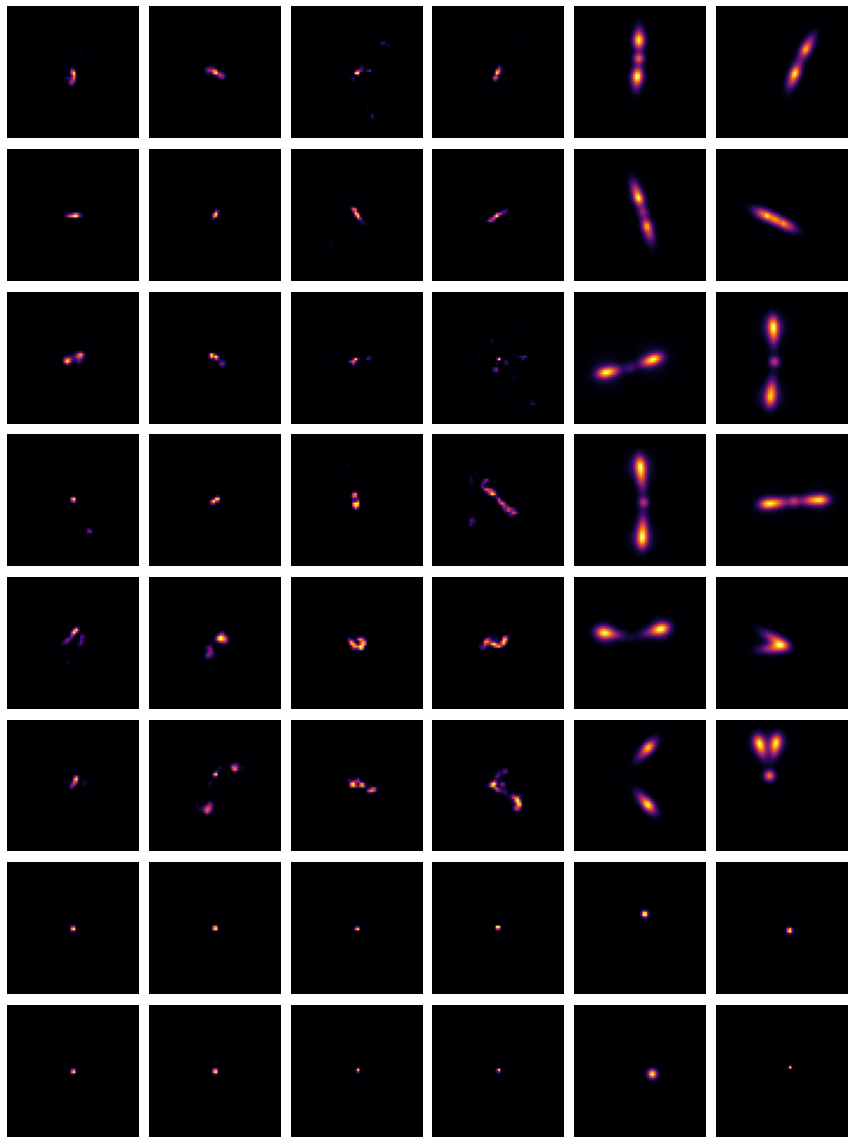

In [18]:
## Create plot for each dataset
size = 2
plt.figure(figsize=(size*6,size*8))

ax = plt.subplot(8, 6, 1)
ax.imshow(aug_train_images[4,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 2)
ax.imshow(aug_train_images[1,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 7)
ax.imshow(aug_train_images[2,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 8)
ax.imshow(aug_train_images[3,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 13)
ax.imshow(aug_train_images[6000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 14)
ax.imshow(aug_train_images[6001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 19)
ax.imshow(aug_train_images[6002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 20)
ax.imshow(aug_train_images[6003,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 25)
ax.imshow(aug_train_images[12000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 26)
ax.imshow(aug_train_images[12001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 31)
ax.imshow(aug_train_images[12002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 32)
ax.imshow(aug_train_images[12003,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 37)
ax.imshow(aug_train_images[18000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 38)
ax.imshow(aug_train_images[18001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 43)
ax.imshow(aug_train_images[18002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 44)
ax.imshow(aug_train_images[18003,:,:,0], cmap='inferno')
plt.axis('off')

ax = plt.subplot(8, 6, 1+2)
ax.imshow(synthetic_images[4,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 2+2)
ax.imshow(synthetic_images[1,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 7+2)
ax.imshow(synthetic_images[2,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 8+2)
ax.imshow(synthetic_images[3,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 13+2)
ax.imshow(synthetic_images[6003,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 14+2)
ax.imshow(synthetic_images[6001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 19+2)
ax.imshow(synthetic_images[6002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 20+2)
ax.imshow(synthetic_images[6005,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 25+2)
ax.imshow(synthetic_images[12000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 26+2)
ax.imshow(synthetic_images[12001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 31+2)
ax.imshow(synthetic_images[12002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 32+2)
ax.imshow(synthetic_images[12003,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 37+2)
ax.imshow(synthetic_images[18000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 38+2)
ax.imshow(synthetic_images[18001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 43+2)
ax.imshow(synthetic_images[18002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 44+2)
ax.imshow(synthetic_images[18003,:,:,0], cmap='inferno')
plt.axis('off')

ax = plt.subplot(8, 6, 1+2+2)
ax.imshow(geo_synthetic_images[4,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 2+2+2)
ax.imshow(geo_synthetic_images[1,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 7+2+2)
ax.imshow(geo_synthetic_images[2,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 8+2+2)
ax.imshow(geo_synthetic_images[3,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 13+2+2)
ax.imshow(geo_synthetic_images[6000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 14+2+2)
ax.imshow(geo_synthetic_images[6001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 19+2+2)
ax.imshow(geo_synthetic_images[6002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 20+2+2)
ax.imshow(geo_synthetic_images[6003,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 25+2+2)
ax.imshow(geo_synthetic_images[12000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 26+2+2)
ax.imshow(geo_synthetic_images[12001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 31+2+2)
ax.imshow(geo_synthetic_images[12002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 32+2+2)
ax.imshow(geo_synthetic_images[12003,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 37+2+2)
ax.imshow(geo_synthetic_images[18000,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 38+2+2)
ax.imshow(geo_synthetic_images[18001,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 43+2+2)
ax.imshow(geo_synthetic_images[18002,:,:,0], cmap='inferno')
plt.axis('off')
ax = plt.subplot(8, 6, 44+2+2)
ax.imshow(geo_synthetic_images[18003,:,:,0], cmap='inferno')
plt.axis('off')

plt.tight_layout()
plt.savefig('/gdrive/My Drive/University of Birmingham/Year 4/Project/temp/last_one.png')
plt.show()

In [10]:
## Train model for multiple datasets

datasets = [train_ds_1, train_ds_2, train_ds_3]

batch_size = 128
epochs = 100
dataset_histories = []
trained_models = []

for dataset in datasets:
    start_time = time.time()
    model = my_model()
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    history = model.fit(dataset.batch(batch_size), validation_data=aug_test_ds.batch(batch_size), epochs=epochs, verbose=2)
    model.evaluate(aug_test_ds.batch(batch_size), verbose=2)
    model.evaluate(test_ds.batch(batch_size), verbose=2)

    dataset_histories.append(history)
    trained_models.append(model)

    print('Time to build and train the model for {} epochs: {:02d}:{:02d}'.format(epochs, *divmod(round(time.time()-start_time), 60)))

Epoch 1/100
188/188 - 4s - loss: 0.8450 - accuracy: 0.6288 - val_loss: 0.6859 - val_accuracy: 0.7010
Epoch 2/100
188/188 - 3s - loss: 0.5411 - accuracy: 0.7961 - val_loss: 0.4549 - val_accuracy: 0.8288
Epoch 3/100
188/188 - 3s - loss: 0.4158 - accuracy: 0.8476 - val_loss: 0.3852 - val_accuracy: 0.8630
Epoch 4/100
188/188 - 3s - loss: 0.3522 - accuracy: 0.8708 - val_loss: 0.3819 - val_accuracy: 0.8608
Epoch 5/100
188/188 - 3s - loss: 0.3170 - accuracy: 0.8866 - val_loss: 0.3351 - val_accuracy: 0.8827
Epoch 6/100
188/188 - 3s - loss: 0.2781 - accuracy: 0.8988 - val_loss: 0.3173 - val_accuracy: 0.8768
Epoch 7/100
188/188 - 3s - loss: 0.2608 - accuracy: 0.9067 - val_loss: 0.3436 - val_accuracy: 0.8748
Epoch 8/100
188/188 - 3s - loss: 0.2217 - accuracy: 0.9203 - val_loss: 0.3184 - val_accuracy: 0.8807
Epoch 9/100
188/188 - 3s - loss: 0.2087 - accuracy: 0.9255 - val_loss: 0.3455 - val_accuracy: 0.8837
Epoch 10/100
188/188 - 3s - loss: 0.2218 - accuracy: 0.9242 - val_loss: 0.3752 - val_accura

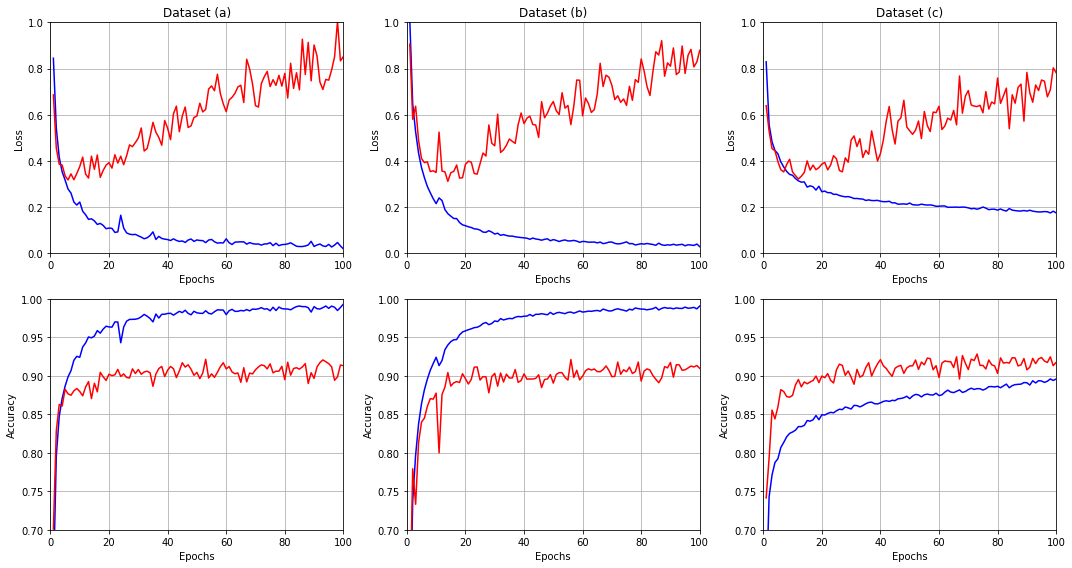

In [14]:
## Plot metrics for each dataset

n = len(datasets)
plot_size = 5
plt.figure(figsize=(n*plot_size, 8))
ds_labels = ['(a)', '(b)', '(c)']

for i in range(n):
    history = dataset_histories[i]
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    # loss plot
    ax = plt.subplot(2, n, i+1)
    ax.plot(range(1,epochs+1), loss, 'b-', label='Training loss')
    ax.plot(range(1,epochs+1), val_loss, 'r-', label='Validation loss')
    ax.set_title('Dataset '+ds_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.grid()
    #ax.legend()

    # acc plot
    ax = plt.subplot(2, n, i+1+n)
    ax.plot(range(1,epochs+1), acc, 'b-', label='Training acc')
    ax.plot(range(1,epochs+1), val_acc, 'r-', label='Validation acc')
    #ax.set_title('Training and validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(0, 100)
    ax.set_ylim(0.7, 1)
    ax.grid()
    #ax.legend()

plt.tight_layout()
plt.savefig('/gdrive/My Drive/University of Birmingham/Year 4/Project/temp/acc_loss.png')
plt.show()

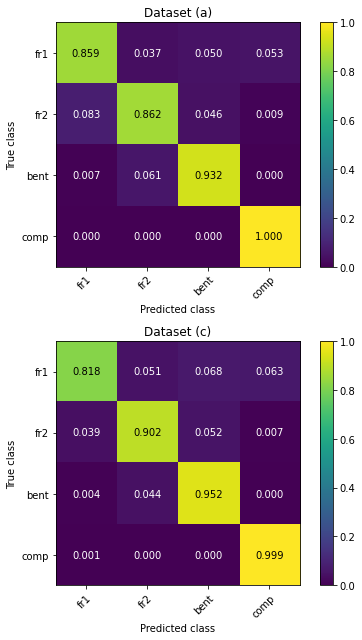

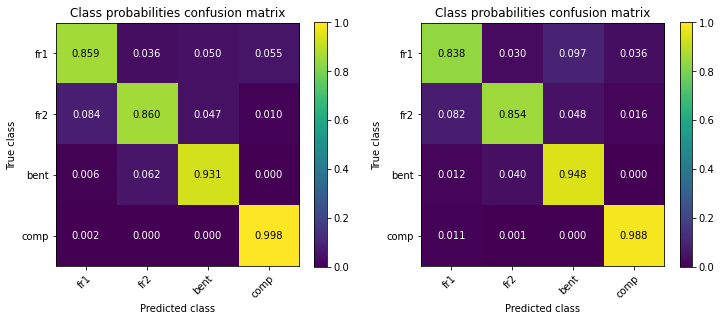

In [33]:
## Plot confusion matrix for each dataset

models = trained_models[0::2]
ds_labels = ['(a)',  '(c)']
n = 2

plot_size = 6
plt.figure(figsize=(plot_size, n*plot_size*3/4))
for i, model in enumerate(models):
    ax = plt.subplot(n, 1, i+1)
    class_names = ['fr1', 'fr2', 'bent', 'comp']
    test_predictions = model.predict_classes(aug_test_images)
    confusion_matrix = tf.math.confusion_matrix(aug_test_labels, test_predictions, num_classes=4)
    plot_confusion_matrix(confusion_matrix.numpy(), ax, title='Dataset '+ds_labels[i], norm=True)
plt.tight_layout()
plt.savefig('/gdrive/My Drive/University of Birmingham/Year 4/Project/temp/conf_mat.png')
    
plt.figure(figsize=(n*plot_size, plot_size*3/4))
for i, model in enumerate(models):
    model = trained_models[i]
    ax = plt.subplot(1, n, i+1)
    class_names = ['fr1', 'fr2', 'bent', 'comp']
    test_predictions = model.predict(aug_test_images)
    one_hot_test_labels = tf.one_hot(aug_test_labels, 4)
    confusion_matrix = compute_confusion_matrix(one_hot_test_labels, test_predictions, 4)
    plot_confusion_matrix(confusion_matrix, ax, title='Class probabilities confusion matrix', norm=True)

In [29]:
## CNN model
time2 = time.time()

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
aug_test_ds = tf.data.Dataset.from_tensor_slices((aug_test_images, aug_test_labels))
#ds = tf.data.Dataset.from_tensor_slices((aug_train_images, aug_train_labels)).shuffle(len(aug_train_images))
ds = train_ds_2
#ds = train_ds_3

input_shape = test_images.shape[1:]
print('input shape:',input_shape)

model = my_model()

# Hyper-parameters
batch_size = 128
# Learning Rate = 0.0001 # tf.keras.optimizers.Adam(1e-4)
epochs = 100

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(ds.batch(batch_size), validation_data=aug_test_ds.batch(batch_size), epochs=epochs)
print('\n')
model.evaluate(aug_test_ds.batch(batch_size), verbose=2)

time3 = time.time()
print('Time to build and train the model for {} epochs: {:02d}:{:02d}'.format(epochs, *divmod(round(time3-time2), 60)))

input shape: (56, 56, 1)
Epoch 1/100
375/375 [==============================] - 14s 37ms/step - loss: 0.9230 - accuracy: 0.5881 - val_loss: 0.7310 - val_accuracy: 0.6788
Epoch 2/100
375/375 [==============================] - 13s 36ms/step - loss: 0.6219 - accuracy: 0.7525 - val_loss: 0.5408 - val_accuracy: 0.8205
Epoch 3/100
375/375 [==============================] - 13s 36ms/step - loss: 0.4795 - accuracy: 0.8183 - val_loss: 0.4860 - val_accuracy: 0.8483
Epoch 4/100
375/375 [==============================] - 13s 36ms/step - loss: 0.3994 - accuracy: 0.8518 - val_loss: 0.4869 - val_accuracy: 0.8450
Epoch 5/100
375/375 [==============================] - 14s 36ms/step - loss: 0.3477 - accuracy: 0.8720 - val_loss: 0.4589 - val_accuracy: 0.8608
Epoch 6/100
375/375 [==============================] - 13s 34ms/step - loss: 0.3696 - accuracy: 0.8661 - val_loss: 0.4362 - val_accuracy: 0.8617
Epoch 7/100
375/375 [==============================] - 13s 36ms/step - loss: 0.3029 - accuracy: 0.8896 - 

KeyboardInterrupt: ignored

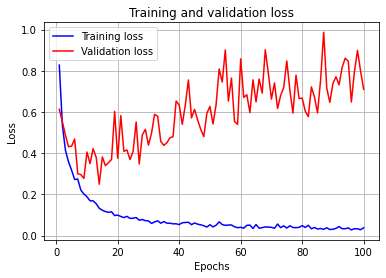

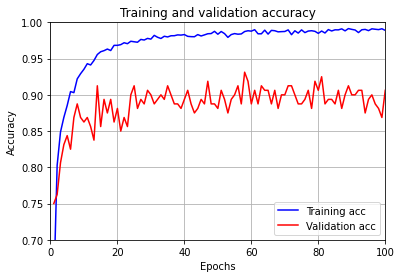

In [17]:
## Plot metrics
# model.fit() returns a History object that contains a dictionary with everything that happened during training

history_dict = history.history
#print('history_dict keys:', history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(range(1,epochs+1), loss, 'b-', label='Training loss')
plt.plot(range(1,epochs+1), val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
#plt.savefig('loss.png')
plt.show()

plt.clf() # clear figure
plt.plot(range(1,epochs+1), acc, 'b-', label='Training acc')
plt.plot(range(1,epochs+1), val_acc, 'r-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0,100)
plt.ylim(0.7, 1)
plt.grid()
plt.legend()
#plt.savefig('accuracy.png')
plt.show()

In [0]:
# Plot confusion matrix

def plot_confusion_matrix(cm, title=None, threshold=None, textcolors=['w', 'k'], norm=False):
    y, x = cm.shape
    if norm: cm = cm / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    vmin, vmax = 0, np.max(cm.sum(axis=1))
    im = ax.imshow(cm, vmin=vmin, vmax=vmax)

    cbar = ax.figure.colorbar(im)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(y))
    ax.set_yticks(np.arange(x))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')

    # Normalize the threshold to the images color range (for text annotation color)
    if threshold is not None: threshold = im.norm(threshold)
    else: threshold = im.norm(cm.max())/2.

    kw = dict(ha="center", va="center")

    for i in range(y):
        for j in range(x):
            kw.update(color=textcolors[int(im.norm(cm[i, j]) > threshold)])
            text = ax.text(j, i, "{:.2f}".format(cm[i, j]), **kw)

    ax.set_title(title)
    fig.tight_layout()
    plt.show()


test_predictions = model.predict_classes(test_images)
confusion_matrix = tf.math.confusion_matrix(test_labels, test_predictions, num_classes=4)
plot_confusion_matrix(confusion_matrix.numpy(), title='Class prediction confusion matrix')

def compute_confusion_matrix(true, pred, num_classes):
    result = np.zeros((num_classes, num_classes))
    for i in range(len(true)):
        result += np.matmul(np.reshape(true[i], (num_classes,1)), np.reshape(pred[i], (1,num_classes)))
        #alt: result[test_label,:] = pred (not using one hot encoding)
    return result

test_predictions = model.predict(test_images)
one_hot_test_labels = tf.one_hot(test_labels, 4)
confusion_matrix = compute_confusion_matrix(one_hot_test_labels, test_predictions, 4)
plot_confusion_matrix(confusion_matrix, title='Class probabilities confusion matrix')

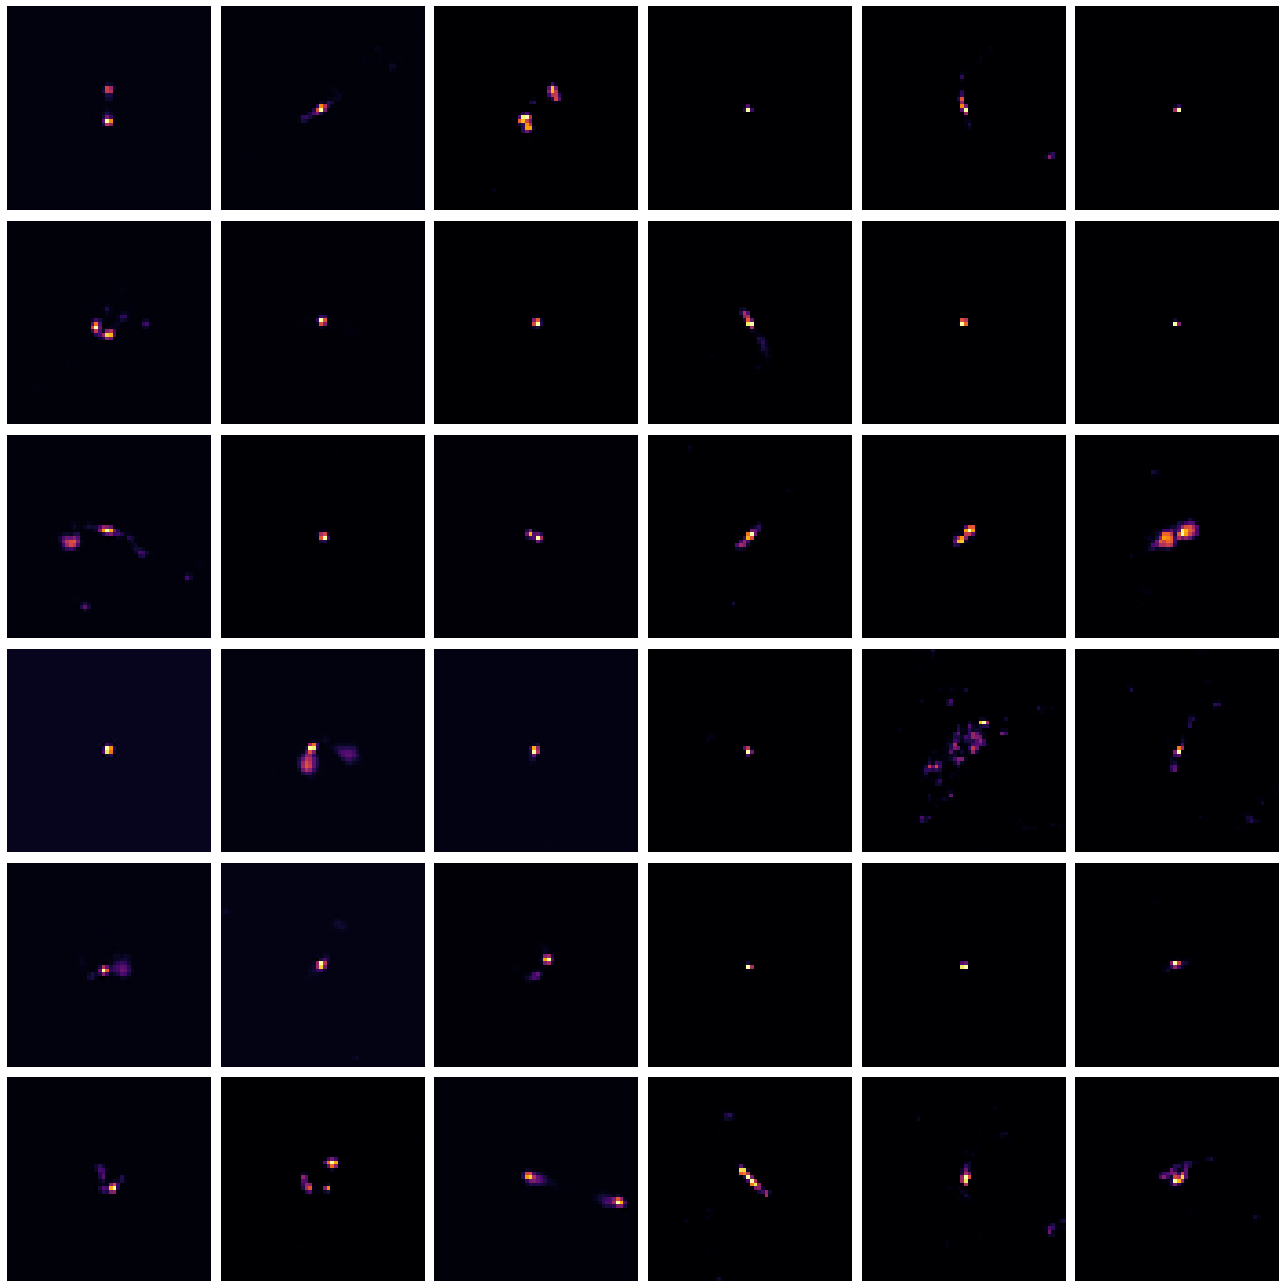

In [57]:
## Compare real and generated images

datasets = [aug_train_images, synthetic_images]

n = 6*6
plot_size = 3
plt.figure(figsize=(6*plot_size, 6*plot_size))

for i in range(n):
    ax = plt.subplot(6, 6, i+1)
    idx = np.random.randint(24000)
    images = datasets[i//3%2]
    ax.imshow(images[idx,:,:,0], cmap='inferno')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [54]:
synthetic_images.shape

(24000, 56, 56, 1)